In [1]:
import numpy as np
import pImpactR as impact
import matplotlib.pyplot as plt
int = np.vectorize(int)

In [2]:
NTURN = np.array([1024,2048])
nCore_y = 4
nCore_z = 2
order = 1

In [3]:
with open('./Lambda5/SFcoefficients.dat','r') as f:
    lines = f.readlines()

for i in range(len(lines)):
    lines[i] = lines[i][:25] + '0.0  \n'
    
with open('./SFcoefficients.dat','w') as f:
    f.writelines(lines)

In [4]:
beam, lattice = impact.readInputFile('./Lambda5/test.SF.in')

beam.nCore_y = nCore_y
beam.nCore_z = nCore_z
beam.distribution.distribution_type = 'ReadFile'

ke   = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

lattice = impact.clearLattice(lattice)
betx = lattice[0].betx
alfx = 0.0
NL_c = lattice[0].transverse_scale_c

x0 = betx**0.5*NL_c

reading ImpactZ input file (./Lambda5/test.SF.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


# Beam Core

In [5]:
# pData = np.loadtxt('partcl_NoSC_cutoff7.data',skiprows=1)
pData = impact.readParticleData('partcl_NoSC_cutoff7.data',ke,mass,freq)

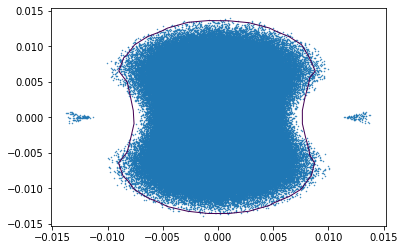

In [6]:
counts,xbins,ybins=np.histogram2d(pData[:,0],pData[:,2],bins=16)

plt.contour(counts.transpose(),
            extent=[np.min(pData[:,0]),np.max(pData[:,0]),np.min(pData[:,2]),np.max(pData[:,2])],
            linewidths=1,linestyles='solid',levels=[250])
plt.scatter(pData[:,0],pData[:,2],s=0.2)

# test particles

In [7]:
nx = 100
testP = 0.0
sig = 0.015
k=0
q_m = beam.multi_charge.q_m[0]
pTest = []
for x in np.linspace(-sig,sig,nx):
    for y in np.linspace(-sig,sig,nx):
        if x**2+y**2<=sig**2 :
            k+=1
            pTest.append([x,0.0,y,0.0,0.0,0.0,q_m,0.0,k])            
            
pTest = np.array(pTest)
impact.writeParticleData(pTest, ke, mass, freq)

npt = len(pTest)
beam.n_particles = npt
npt

7668

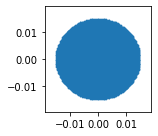

In [8]:
plt.figure(figsize=(2.3,2))
plt.scatter(pTest[:,0],pTest[:,2],s=0.4)
plt.tight_layout()

# lattice

In [9]:
lattice

[
              length: 1.8 [m]
            n_sckick: 100 [1]
               n_map: 10 [1]
          strength_t: 0.4
  transverse_scale_c: 0.01
         pipe_radius: 10.0 [m]
                betx: 1.2732395447351628 [m]
                type: 'nonlinear_insert_smooth_focusing']

In [10]:
Loop = impact.getElem('loop')
Loop.turns = NTURN[0]
lattice.insert(0,Loop)

TBT = impact.getElem('TBT')
TBT.file_id = NTURN[0]
TBT.pID_begin = 1
TBT.pID_end = npt
lattice.insert(1,TBT)

OUTPUT = impact.getElem('write_raw_ptcl')
OUTPUT.file_id = NTURN[0]
OUTPUT.turn = NTURN[0]
OUTPUT.format_id = 2
lattice.append(OUTPUT)

# run

In [11]:
impact.writeInputFile(beam,lattice,'test.in.'+str(NTURN[0]))
impact.writeInputFile(beam,lattice)
# impact.run(beam,order=order)

In [12]:
for nturn in NTURN[:-1]:
    lattice[0].turns = nturn
    TBT.file_id = nturn*2
    OUTPUT.turn = nturn
    OUTPUT.file_id = nturn*2
    beam.distribution.distribution_type = 'ReadFile_binary'
    beam.distribution.file_id = nturn
    impact.writeInputFile(beam,lattice,'test.in.'+str(nturn*2) )
    impact.writeInputFile(beam,lattice)
#     impact.run(beam,order=order)

# read simulation data

In [13]:
iTBT = {}
TBT = {}
X = {}
Y = {}
Npt = {}

for nturn in NTURN:
    print(nturn)
    iTBT[nturn],TBT[nturn] = impact.readTBT(nturn,ke,mass,freq)
    TBT[nturn] = TBT[nturn][:,:4,:]
    Npt[nturn] = len(iTBT[nturn])

1024
2048


In [14]:
for i in range(len(NTURN)):
    nturn = NTURN[i]
    
    npt = len(iTBT[nturn])
    X[nturn]=np.zeros((nturn,npt),dtype=np.complex)
    Y[nturn]=np.zeros((nturn,npt),dtype=np.complex)
    
    iturn = 0
    for j in range(i+1):
        jturn = NTURN[j]
        
        itmp = np.in1d(iTBT[jturn],iTBT[nturn])
        tmp = TBT[jturn][:,:,itmp]
        X[nturn][iturn:jturn] = tmp[:,0,:] - 1j*betx*tmp[:,1,:]
        Y[nturn][iturn:jturn] = tmp[:,2,:] - 1j*betx*tmp[:,3,:]
        print(iturn,jturn,nturn,np.sum(itmp),npt)
        iturn = jturn

0 1024 1024 7668 7668
0 1024 2048 7668 7668
1024 2048 2048 7668 7668


# apply NAFF

In [15]:
def getClosestDiff(ref,arr):
    # ref.shape = nSample
    nMode = len(arr)
    if ref>1.0:
        ref = ref - 1.0
    for i in range(nMode):
        if arr[i]>1.0:
            arr[i]=arr[i]-1.0
        if arr[i]<=0.0:
            arr[i]=arr[i]+1.0
    diff = np.abs(ref - arr)
    for i in range(nMode):
        if (diff[i]>0.5):
            diff[i] = 1.0 - diff[i]
    return np.min(diff)

In [16]:
iMax = {}
iMin = {}
tuneXbefore= {}
tuneYbefore= {}
Xdiff = {}
Ydiff = {}
Adiff = {}

for nturn in NTURN[1:]:
    npt = len(X[nturn][0,:])
    tuneXbefore[nturn] = np.zeros(npt)
    tuneYbefore[nturn] = np.zeros(npt)
    Xdiff[nturn] = np.zeros(npt)
    Ydiff[nturn] = np.zeros(npt)
    Adiff[nturn] = np.zeros(npt)
    for i in range(npt):
        signal = X[nturn][:int(nturn/2),i] -np.mean(X[nturn][:int(nturn/2),i])
        tuneXbefore[nturn][i],amp,dummy = impact.util.naff(1,signal,window_id=1)
        signal = X[nturn][int(nturn/2):,i] -np.mean(X[nturn][int(nturn/2):,i])
        tune,amp,dummy = impact.util.naff(3,signal,window_id=1)
        Xdiff[nturn][i] = getClosestDiff(tuneXbefore[nturn][i],tune)
        
        signal = Y[nturn][:int(nturn/2),i] -np.mean(Y[nturn][:int(nturn/2),i])
        tuneYbefore[nturn][i],amp,dummy = impact.util.naff(1,signal,window_id=1)
        signal = Y[nturn][int(nturn/2):,i] -np.mean(Y[nturn][int(nturn/2):,i])
        tune,amp,dummy = impact.util.naff(3,signal,window_id=1)
        Ydiff[nturn][i] = getClosestDiff(tuneYbefore[nturn][i],tune)
        
    Adiff[nturn] = np.sqrt(Xdiff[nturn]**2 +Ydiff[nturn]**2)
    Adiff[nturn] = np.log10(Adiff[nturn]+1.0e-6)
    Xdiff[nturn] = np.log10(Xdiff[nturn]+1.0e-6)
    Ydiff[nturn] = np.log10(Ydiff[nturn]+1.0e-6)
    iMax[nturn] = np.argmax(Adiff[nturn]),np.argmax(Xdiff[nturn]),np.argmax(Ydiff[nturn])
    iMin[nturn] = np.argmin(Adiff[nturn]),np.argmin(Xdiff[nturn]),np.argmin(Ydiff[nturn])

# Plot

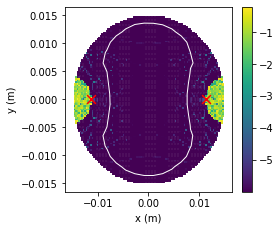

In [17]:
xmax = sig
for n in NTURN[1:]:
    fig = plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Adiff[n],s=1.6,marker='s')
    plt.scatter([-x0,x0],[0,0],c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.contour(counts.transpose(),
            extent=[np.min(pData[:,0]),np.max(pData[:,0]),np.min(pData[:,2]),np.max(pData[:,2])],
            linewidths=1,colors='white',linestyles='solid',levels=[250])
    plt.colorbar(f1)
    plt.tight_layout()
    plt.savefig('FMA.SmoothFocusing.turn='+str(int(n/2))+'.png', dpi=180, bbox_inches = "tight")